In [61]:
!pip install shap

In [62]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap

In [63]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [64]:
file_path = '/content/drive/My Drive/Cibil/Master_Loan_Summary.csv'

In [65]:
df = pd.read_csv(file_path)

<ipython-input-65-47c250c455f0>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [66]:
df.head()

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,origination_date,listing_title,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,last_payment_date,next_payment_due_date,days_past_due,loan_status_description,data_source
0,10149342,27050.0,36,0.1099,885.46,B,2013-12-01T00:00,debt_consolidation,0.0,27050.0,4702.53,0.0,0.0,2016-07-01T00:00,2016-08-01T00:00,0,COMPLETED,Lending Club
1,10149488,4800.0,36,0.1099,157.13,B,2013-12-01T00:00,home_improvement,0.0,4800.0,357.52,0.0,0.0,2014-09-01T00:00,2014-10-01T00:00,0,COMPLETED,Lending Club
2,10148122,12000.0,36,0.0762,373.94,A,2013-12-01T00:00,debt_consolidation,0.0,12000.0,1397.54,0.0,0.0,2016-06-01T00:00,2016-07-01T00:00,0,COMPLETED,Lending Club
3,10119623,12000.0,36,0.1199,398.52,B,2013-12-01T00:00,debt_consolidation,0.0,12000.0,2346.48,0.0,0.0,2017-01-01T00:00,2017-02-01T00:00,0,COMPLETED,Lending Club
4,10159498,12000.0,36,0.0662,368.45,A,2013-12-01T00:00,debt_consolidation,0.0,12000.0,1263.95,0.0,0.0,2017-01-01T00:00,2017-02-01T00:00,0,COMPLETED,Lending Club


In [67]:
df = df.dropna() #removes rows with missing values from the dataframe

In [68]:
df['origination_date'] = pd.to_datetime(df['origination_date'], errors='coerce', utc=True) #convert orgination date to datetime object
df['last_payment_date'] = pd.to_datetime(df['last_payment_date'], errors='coerce', utc=True)
df['loan_age'] = (df['last_payment_date'] - df['origination_date']).dt.days / 365 # Calculates the loan age in years by subtracting origination date from last payment date.

In [69]:
selected_features = ['amount_borrowed', 'term', 'borrower_rate', 'installment','principal_paid', 'interest_paid',  'loan_age']

In [70]:
le = LabelEncoder()
df['grade'] = le.fit_transform(df['grade'])  # 'A'-'G' -> 0-6

X = df[selected_features]

y = df['grade']

In [71]:
numerical_transformer = StandardScaler() #Scales numerical features to have zero mean and unit variance
categorical_transformer = OneHotEncoder() #Converts categorical features into numerical representations using one-hot encoding.

In [72]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, selected_features)
    ])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [74]:
#RandomForestClassifier

rfc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))
])

In [75]:
rfc_pipeline.fit(X_train, y_train)
rfc_preds = rfc_pipeline.predict(X_test)

📘 RandomForest Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.94      0.97     70377
           B       0.94      0.93      0.94    117489
           C       0.91      0.95      0.93    117939
           D       0.85      0.90      0.88     59334
           E       0.77      0.73      0.75     25829
           F       0.80      0.60      0.68      8796
           G       0.99      0.39      0.56      2650

    accuracy                           0.91    402414
   macro avg       0.89      0.78      0.81    402414
weighted avg       0.91      0.91      0.91    402414

Accuracy: 0.9119861635032578


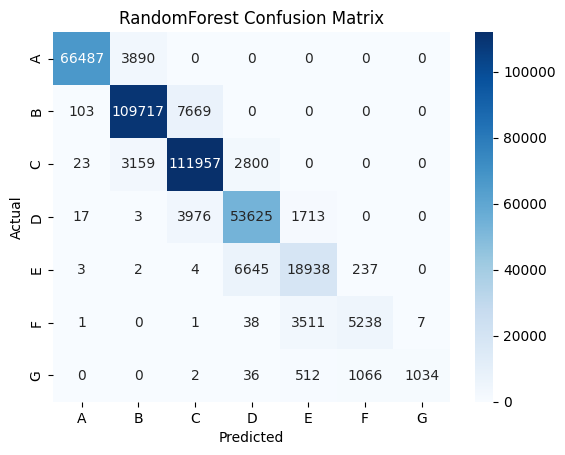

In [76]:
print("RandomForest Classification Report:")
print(classification_report(y_test, rfc_preds, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test, rfc_preds))
sns.heatmap(confusion_matrix(y_test, rfc_preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("RandomForest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [77]:
# XGBoostClassifier
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                                 n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42))
])

In [78]:
xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:48:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📙 XGBoost Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.99      1.00     70377
           B       0.98      0.97      0.98    117489
           C       0.96      0.96      0.96    117939
           D       0.91      0.95      0.93     59334
           E       0.88      0.87      0.87     25829
           F       0.84      0.80      0.82      8796
           G       0.79      0.71      0.75      2650

    accuracy                           0.96    402414
   macro avg       0.91      0.89      0.90    402414
weighted avg       0.96      0.96      0.96    402414

Accuracy: 0.9573076483422545


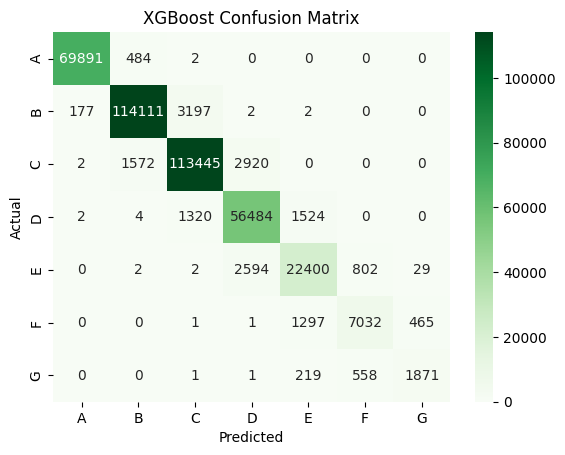

In [79]:
print("\n XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test, xgb_preds))
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [80]:
#  Pipelines
joblib.dump(rfc_pipeline, '/content/rfc_grade_model_pipeline.joblib')

['/content/rfc_grade_model_pipeline.joblib']

In [81]:
# Save XGBoost pipeline
joblib.dump(xgb_pipeline, '/content/xgb_grade_model_pipeline.joblib')

['/content/xgb_grade_model_pipeline.joblib']

In [82]:
# Extract and Save Scaler Separately
scaler_from_pipeline = rfc_pipeline['preprocessor'].transformers_[0][1]
joblib.dump(scaler_from_pipeline, '/content/grade_scaler.joblib')

['/content/grade_scaler.joblib']

In [83]:
from google.colab import files
files.download('/content/rfc_grade_model_pipeline.joblib')
files.download('/content/xgb_grade_model_pipeline.joblib')
files.download('/content/grade_scaler.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
X_transformed = preprocessor.transform(X_test)  # preprocessed input data
model_xgb = xgb_pipeline.named_steps['classifier']  # raw XGBoost model

In [ ]:
# Create SHAP explainer
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_transformed)

In [ ]:
# Plot SHAP summary
shap.summary_plot(shap_values, features=X_transformed, feature_names=selected_features)

In [ ]:
# SHAP bar plot (mean absolute SHAP values)
shap.plots.bar(shap_values)